In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from tqdm.notebook import tqdm

from sklearn.naive_bayes import GaussianNB
from itertools import combinations
from mne.time_frequency import tfr_morlet

plt.style.use('seaborn-whitegrid')

df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
thold = 3.5
gt['lh'] = (gt[['h']] > thold) * 1
gt['le'] = (gt[['e']] > thold) * 1
gt['lx'] = (gt[['x']] > thold) * 1
gt['la'] = (gt[['a']] > thold) * 1
gt['lc'] = (gt[['c']] > thold) * 1
gt['lo'] = (gt[['o']] > thold) * 1

In [2]:
# import os
# os.getcwd()

'/home/jovyan/work/2021JanHCI/3-preprocess'

In [2]:
path, folders, filenames = next(walk('./data'))
# Exclude these data because of incomplete data
gt.drop([11,4,36],inplace=True)

filenames.remove('11-audio.csv')
filenames.remove('11-image.csv')

filenames.remove('36-audio.csv')
filenames.remove('36-image.csv')

In [3]:
path = './data'
columns = {'Unnamed: 1':'Fp1',
        'Unnamed: 2':'Fp2',
        'Unnamed: 3':'F3',
        'Unnamed: 4':'F4',
        'Unnamed: 5':'F7',
        'Unnamed: 6':'F8',
        'Unnamed: 7':'P7',
        'Unnamed: 8':'P8'}

EEG_audio, EEG_image = dict(), dict()
from itertools import product
categories = [1,2,3,4,5]
blocks = [1,2]
for filename in tqdm(filenames):
    participant_id, stimuli = filename.split('-')
    stimuli = stimuli.rstrip('.csv')
    data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
    # print(participant_id, stimuli)
    # experiment = dict()
    # for (category, block) in product(categories,blocks):
        # print("   ", category, block)
        # section = get_section_from_catblock(data, category=category,block=block)
        # experiment[f"{category}_{block}"] = section
    if(stimuli == 'audio'):
        EEG_audio[int(participant_id)] = data
    elif(stimuli == 'image'):
        EEG_image[int(participant_id)] = data
    else:
        raise ValueError(f"Stimuli:{stimuli} is unexpected.")

  0%|          | 0/60 [00:00<?, ?it/s]

In [114]:
# Preprocess data + feature extraction using wavelet 'morlet'
def get_data_wt():
    X = None
    # y = []
    Y = None
    participant_id = []
    categories = []
    # 'DELTA' 'THETA' 'ALPHA' 'BETA' 'Gamma'
    # https://reader.elsevier.com/reader/sd/pii/S0957417410005695?token=99F7CC487CECF9C17E36713347D0F8372A289AC2C6331A2B6C4F272CD34921FD8B418EB417C0F9C3796CEA271FB4455D&originRegion=eu-west-1&originCreation=20210510142445
    filter_list = np.array([4,8,13,30,125])
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in tqdm(ids):
        data = None
        for eeg_type in ['image','audio']:
            if(eeg_type == 'image'): raw = dataframe_to_raw(EEG_image[id], sfreq=250)
            else:                    raw = dataframe_to_raw(EEG_audio[id], sfreq=250)

            raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
            raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift

            events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
            events = np.delete(events,np.argwhere(events[:,2] != 1), axis=0)
            if(events.shape[0] != 9):
                raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
            epochs = mne.Epochs(raw, events, tmin=0, tmax=15, baseline=(0,0), verbose=False)
            if(epochs.get_data().shape[0] != 9):
                raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

            for e in epochs.iter_evoked():
                e = e.data[:8,:]
                e = np.mean(e,axis=0)
                e = np.expand_dims(e, axis=0)
                if(type(data) == type(None)): data = e
                else: data = np.concatenate([data,e],axis=0)
        data = np.expand_dims(data, axis=0)
        if(type(X) == type(None)): X = data
        else: X = np.concatenate( [X, data], axis=0 )
        print(X.shape)
        # break
    return X, ids
        # epochs.average().plot()
        # powers = tfr_morlet(epochs, freqs=filter_list, n_cycles=filter_list / 2., return_itc=False, average=False, verbose=False)
        # # features = np.mean(powers.data, axis=3)
        # features = powers.data
        # # print(features.shape) #(50,8,5,)
        # for e in range(features.shape[0]):
        #     row = np.expand_dims(features[e], axis=0)
        #     row = 10 * np.log10(row)

        #     # y.append(gt.loc[id]['label'])

        #     label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
        #     label = np.expand_dims(label, axis=0)
        #     if(type(Y) == type(None)): Y = label
        #     else: Y = np.concatenate( [Y, label ], axis=0 )
        #     participant_id.append(id)
        # for e in events[:,2]:
        #     categories.append(str(e)[0])
        # print(X.shape)
            # print(Y.shape)
    # y = np.array(y)
    # return X,Y,np.array(participant_id),np.array(categories)

In [115]:
import warnings
warnings.filterwarnings("ignore")
X,y = get_data_wt()

  0%|          | 0/30 [00:00<?, ?it/s]

(1, 18, 3751)
(2, 18, 3751)
(3, 18, 3751)
(4, 18, 3751)
(5, 18, 3751)
(6, 18, 3751)
(7, 18, 3751)
(8, 18, 3751)
(9, 18, 3751)
(10, 18, 3751)
(11, 18, 3751)
(12, 18, 3751)
(13, 18, 3751)
(14, 18, 3751)
(15, 18, 3751)
(16, 18, 3751)
(17, 18, 3751)
(18, 18, 3751)
(19, 18, 3751)
(20, 18, 3751)
(21, 18, 3751)
(22, 18, 3751)
(23, 18, 3751)
(24, 18, 3751)
(25, 18, 3751)
(26, 18, 3751)
(27, 18, 3751)
(28, 18, 3751)
(29, 18, 3751)
(30, 18, 3751)


In [118]:
print(y)

[2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [116]:
print(X.shape)

(30, 18, 3751)


In [117]:
# import pickle
# with open(f'data_break/X.pickle', 'wb') as handle:
#     pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'data_break/y.pickle', 'wb') as handle:
#     pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
import pickle
with open(f'data_break/X.pickle', 'rb') as handle:
    X = pickle.load(handle)
with open(f'data_break/y.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [10]:
len(list(combinations(list(range(18)),2)))

153

In [3]:
df = pd.DataFrame()

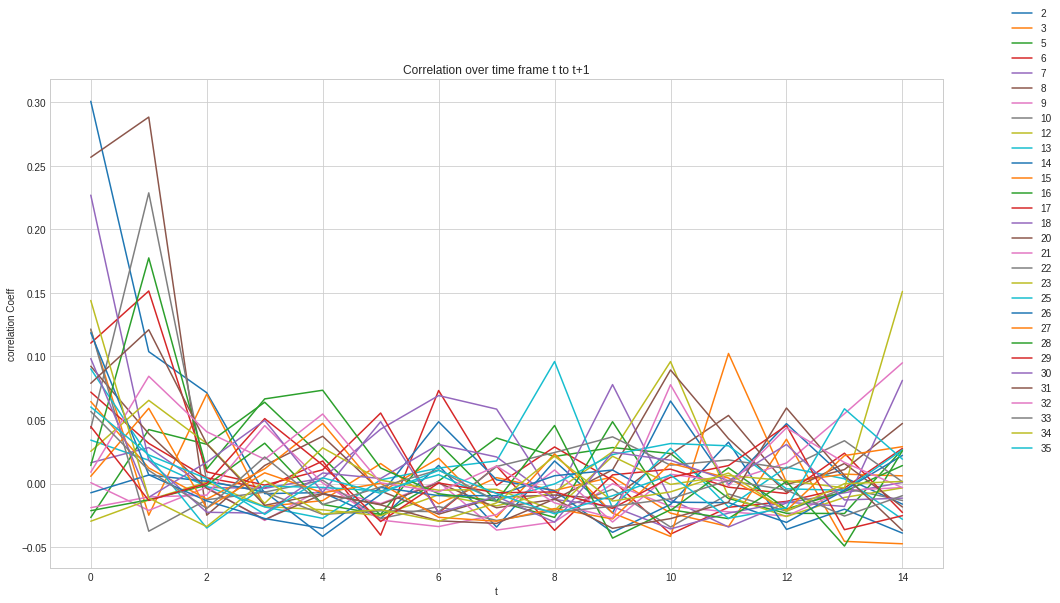

In [4]:
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
fig,ax = plt.subplots(figsize=(16,9))
for index in range(len(y)):
    corr_list = []
    data = X[index]
    # print(y[27])
    for t in times:
        corr_sum = 0
        count = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:250*(t+1)],data[j][250*t:250*(t+1)])
            # print(corr[0][1])
            corr_sum += corr[0][1]
            count+=1
        # print(t, corr_sum)
        corr_list.append(corr_sum/153)
    df[f"{y[index]}"] = corr_list
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation over time frame t to t+1')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()

In [5]:
df.T.to_csv('./data_break/corr.csv')

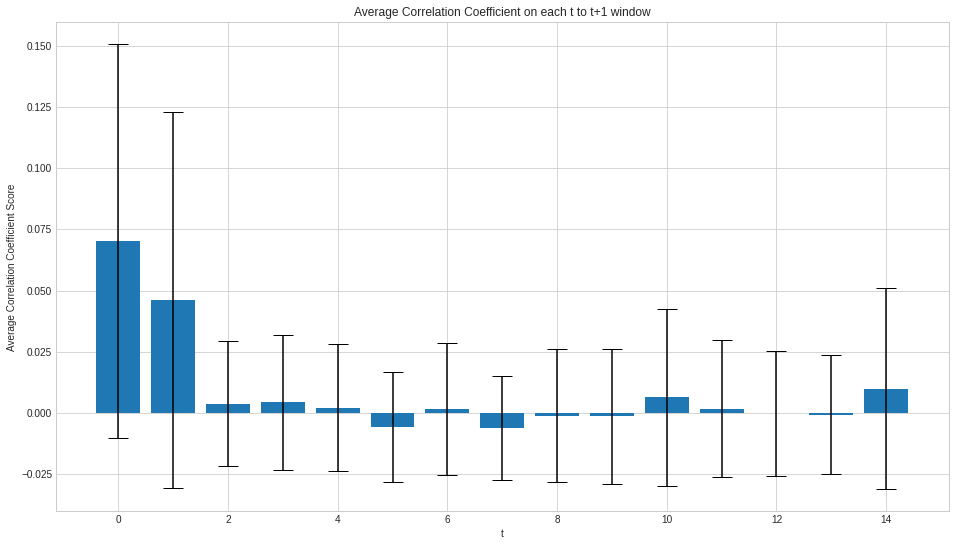

In [17]:
fig,ax = plt.subplots(figsize=(16,9))
ax.bar([14,13,12,11,10,9,8,7,6,5,4,3,2,1,0],np.mean(df,axis=1),yerr=np.std(df,axis=1), ecolor='black', capsize=10)
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.errorbar([14,13,12,11,10,9,8,7,6,5,4,3,2,1,0],np.std(df,axis=1))
ax.set_title("Average Correlation Coefficient on each t to t+1 window")
ax.set_xlabel("t")
ax.set_ylabel("Average Correlation Coefficient Score")
plt.show()

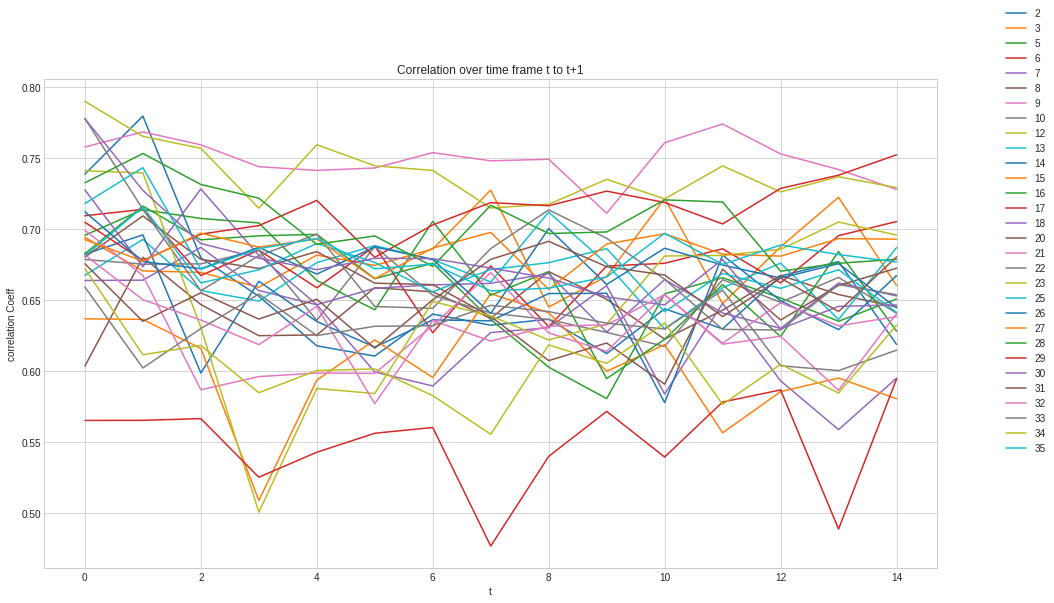

In [37]:
from mne.time_frequency import psd_array_welch
df = pd.DataFrame()
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
fig,ax = plt.subplots(figsize=(16,9))
for index in tqdm(range(len(y))):
    corr_list = []
    data = X[index]
    # print(y[27])
    for t in times:
        corr_sum = 0
        count = 0
        for i,j in combinations(list(range(18)),2):
            psd_i, freq = psd_array_welch(data[i][250*t:250*(t+1)],sfreq=250 ,n_fft = len(data[i][250*t:250*(t+1)]), verbose=False)
            psd_j, freq = psd_array_welch(data[j][250*t:250*(t+1)],sfreq=250 ,n_fft = len(data[j][250*t:250*(t+1)]), verbose=False)
            psd_i = 10 * np.log10(psd_i)
            psd_j = 10 * np.log10(psd_j)
            corr = np.corrcoef([psd_i,psd_j])
            # print(corr[0][1])
            corr_sum += corr[0][1]
            count+=1
        # print(t, corr_sum)
        corr_list.append(corr_sum/153)
    df[f"{y[index]}"] = corr_list
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation over time frame t to t+1')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()


<BarContainer object of 15 artists>

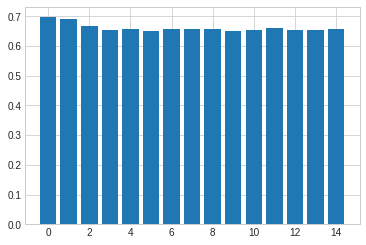

In [39]:
plt.bar([14,13,12,11,10,9,8,7,6,5,4,3,2,1,0],np.mean(df,axis=1))

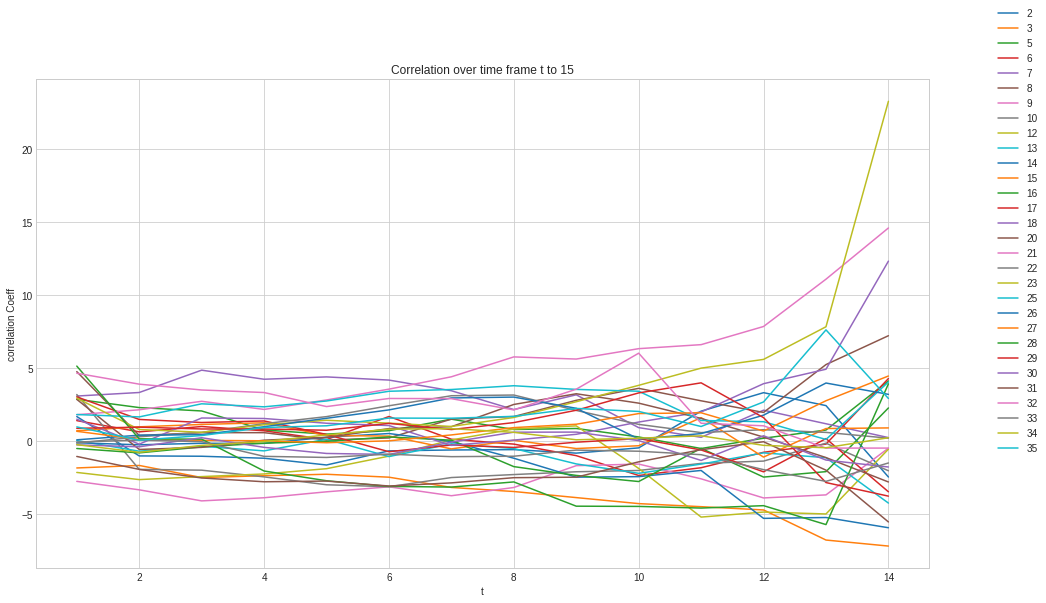

In [173]:
from scipy.signal import correlate
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1]
fig,ax = plt.subplots(figsize=(16,9))
for index in range(len(y)):
    corr_list = []
    data = X[index]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:],data[j][250*t:])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation over time frame t to 15')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()

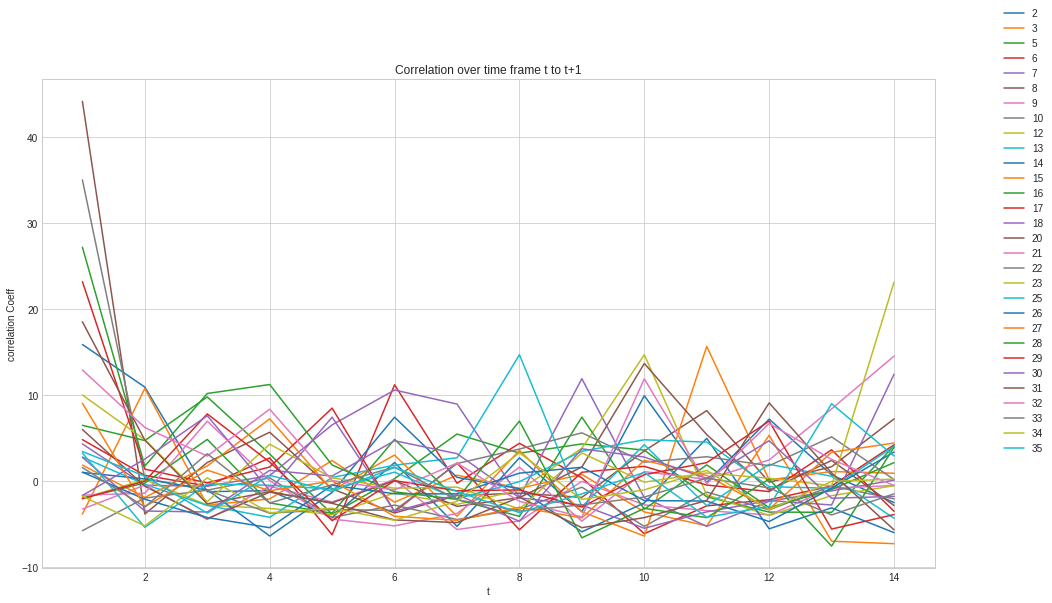

In [172]:
from scipy.signal import correlate
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1]
fig,ax = plt.subplots(figsize=(16,9))
for index in range(len(y)):
    corr_list = []
    data = X[index]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:250*(t+1)],data[j][250*t:250*(t+1)])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation over time frame t to t+1')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()

# Correlation on WT

  0%|          | 0/30 [00:00<?, ?it/s]

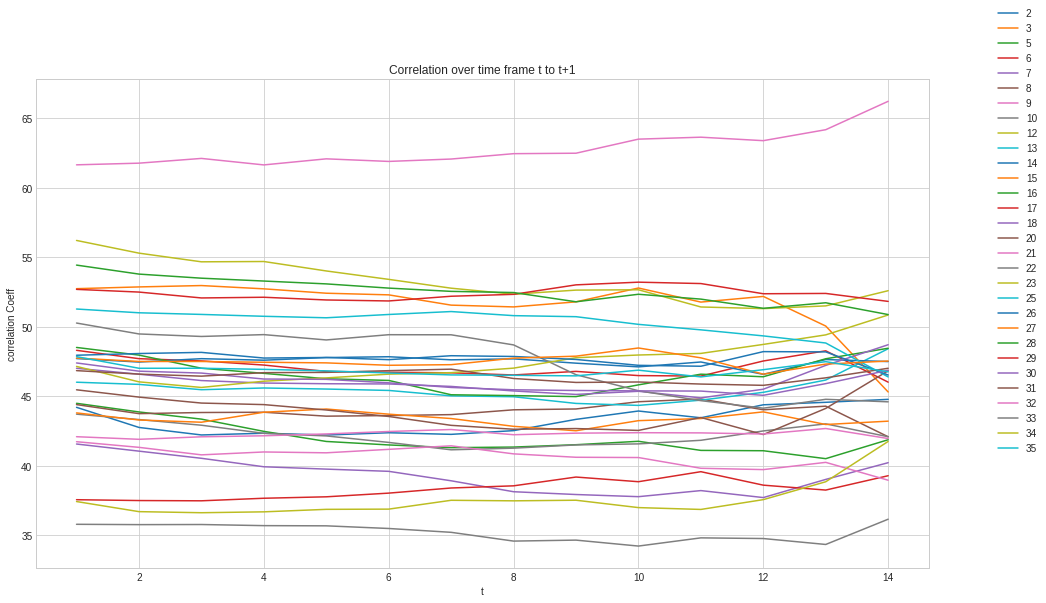

In [206]:
from scipy.signal import correlate
from mne.time_frequency import tfr_array_morlet,psd_array_welch

filter_list = np.array([4,8,13,30,125])
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1]
fig,ax = plt.subplots(figsize=(16,9))
for index in tqdm(range(len(y))):
    corr_list = []
    data = X[index]
    power = tfr_array_morlet(np.expand_dims(data,axis=1),sfreq=250, freqs=filter_list, n_cycles=filter_list / 2., verbose=False)
    power.squeeze(1).shape
    data =  10 * np.log10(power)
    # print(data.shape)
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            data_i = data[i].squeeze(0)[:,250*t:].reshape(-1)
            data_j = data[j].squeeze(0)[:,250*t:].reshape(-1)
            # break
            corr = np.corrcoef(data_i, data_j)
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation over time frame t to t+1')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()


# Correlated on PSD

  0%|          | 0/30 [00:00<?, ?it/s]

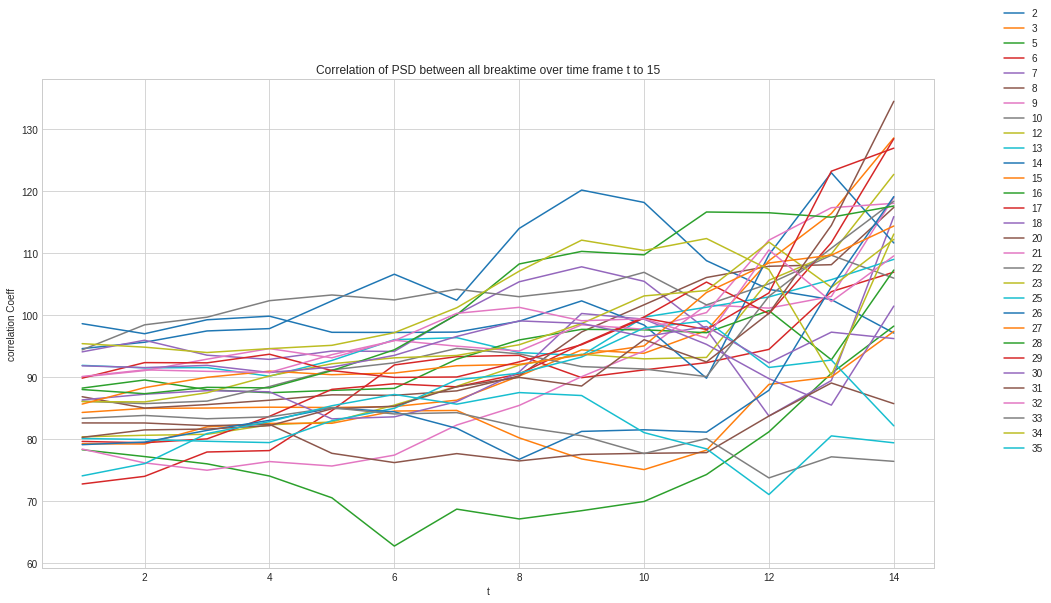

In [238]:
from scipy.signal import correlate
from mne.time_frequency import tfr_array_morlet,psd_array_welch

filter_list = [[30,None],[13,30],[8,13],[4,8],[1,4]]
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1]
fig,ax = plt.subplots(figsize=(16,9))
for index in tqdm(range(len(y))):
    corr_list = []
    data = X[index]
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            psd_i, freq = psd_array_welch(data[i][250*t:],sfreq=250 ,n_fft = len(data[i][250*t:]), verbose=False)
            psd_j, freq = psd_array_welch(data[j][250*t:],sfreq=250 ,n_fft = len(data[j][250*t:]), verbose=False)
            # data_i = data[i][:,250*t:]
            # data_j = data[j][:,250*t:]
            # break
            corr = np.corrcoef(psd_i, psd_j)
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation of PSD between all breaktime over time frame t to 15')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

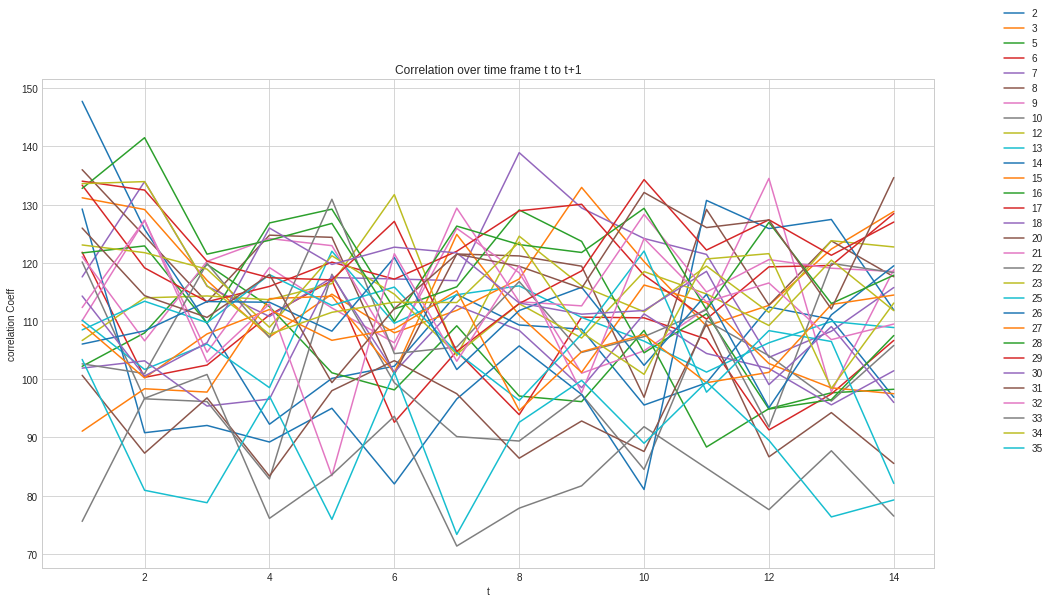

In [237]:
from scipy.signal import correlate
from mne.time_frequency import tfr_array_morlet,psd_array_welch

filter_list = [[30,None],[13,30],[8,13],[4,8],[1,4]]
times = [14,13,12,11,10,9,8,7,6,5,4,3,2,1]
fig,ax = plt.subplots(figsize=(16,9))
for index in tqdm(range(len(y))):
    corr_list = []
    data = X[index]
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            psd_i, freq = psd_array_welch(data[i][250*t:250*(t+1)],sfreq=250 ,n_fft = len(data[i][250*t:250*(t+1)]), verbose=False)
            psd_j, freq = psd_array_welch(data[j][250*t:250*(t+1)],sfreq=250 ,n_fft = len(data[j][250*t:250*(t+1)]), verbose=False)
            # data_i = data[i][:,250*t:250*(t+1)]
            # data_j = data[j][:,250*t:250*(t+1)]
            # break
            corr = np.corrcoef(psd_i, psd_j)
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=y[index])

fig.legend()
ax.set_title('Correlation over time frame t to t+1')
ax.set_xlabel('t')
ax.set_ylabel('correlation Coeff')
plt.show()


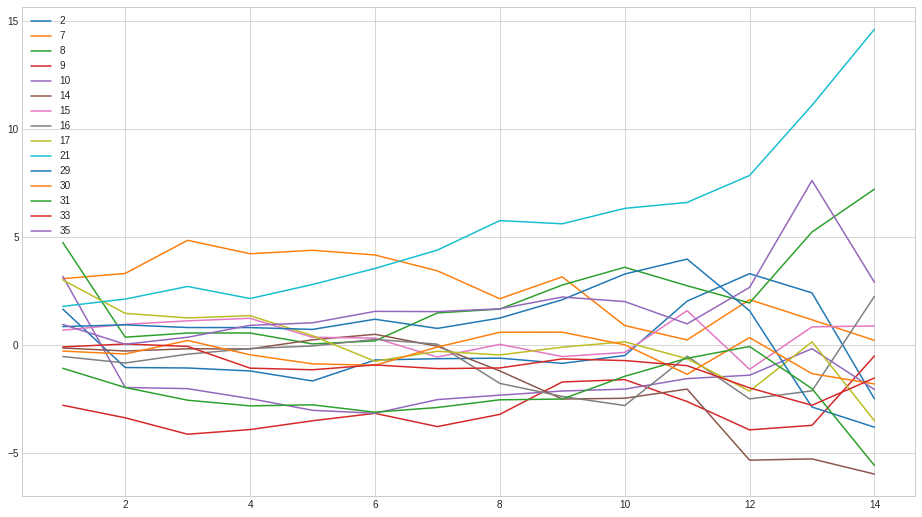

In [162]:
fig,ax = plt.subplots(figsize=(16,9))
for index in gt[gt['lh'] == 1].index:
    corr_list = []
    data = X[y.index(index)]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:],data[j][250*t:])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=index)
ax.legend()
plt.show()

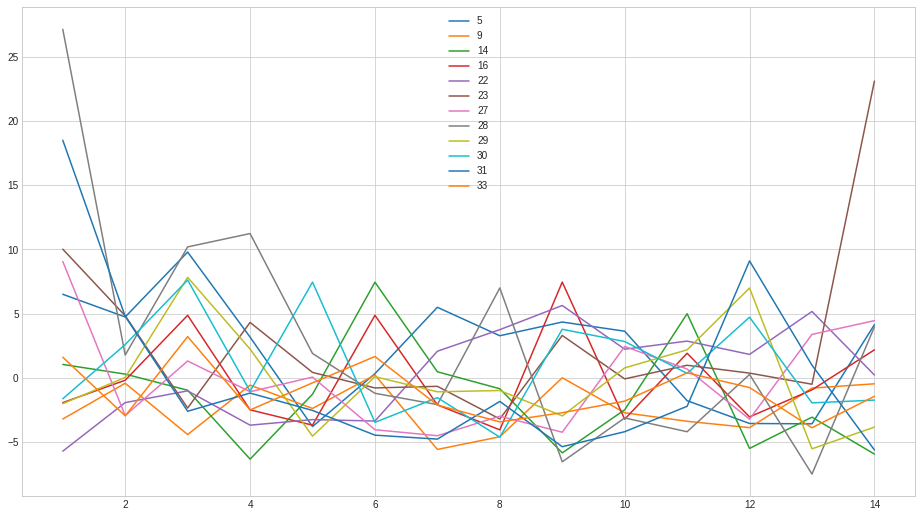

In [169]:
fig,ax = plt.subplots(figsize=(16,9))
for index in gt[gt['le'] == 1].index:
    corr_list = []
    data = X[y.index(index)]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:250*(t+1)],data[j][250*t:250*(t+1)])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=index)
ax.legend()
plt.show()

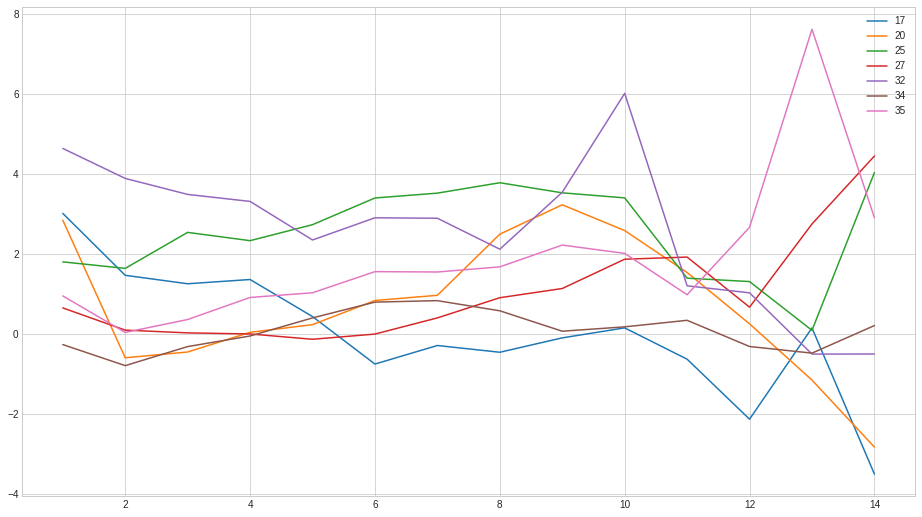

In [164]:
fig,ax = plt.subplots(figsize=(16,9))
for index in gt[gt['lx'] == 1].index:
    corr_list = []
    data = X[y.index(index)]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:],data[j][250*t:])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=index)
ax.legend()
plt.show()

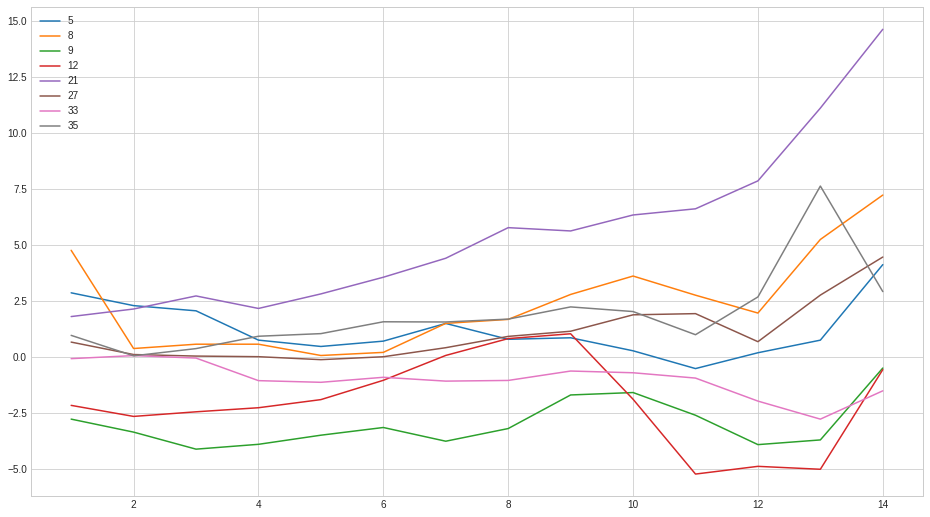

In [165]:
fig,ax = plt.subplots(figsize=(16,9))
for index in gt[gt['la'] == 1].index:
    corr_list = []
    data = X[y.index(index)]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:],data[j][250*t:])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=index)
ax.legend()
plt.show()

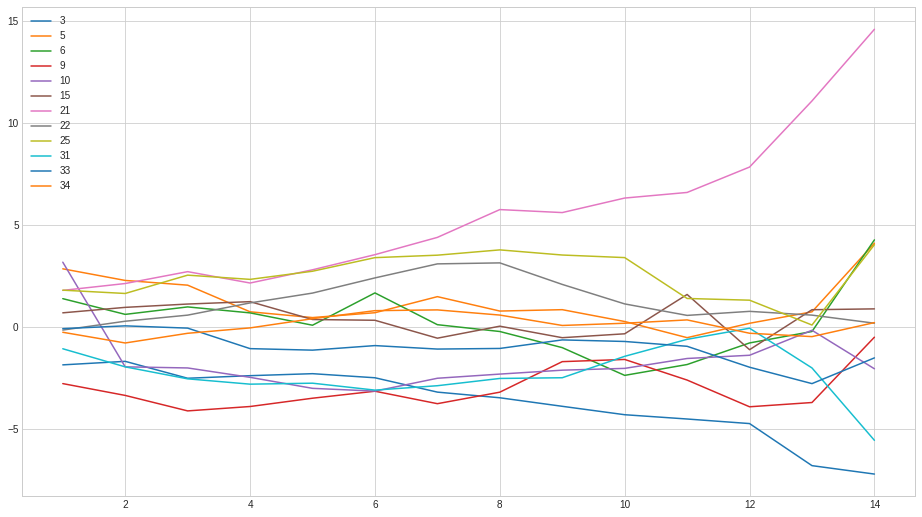

In [166]:
fig,ax = plt.subplots(figsize=(16,9))
for index in gt[gt['lc'] == 1].index:
    corr_list = []
    data = X[y.index(index)]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:],data[j][250*t:])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=index)
ax.legend()
plt.show()

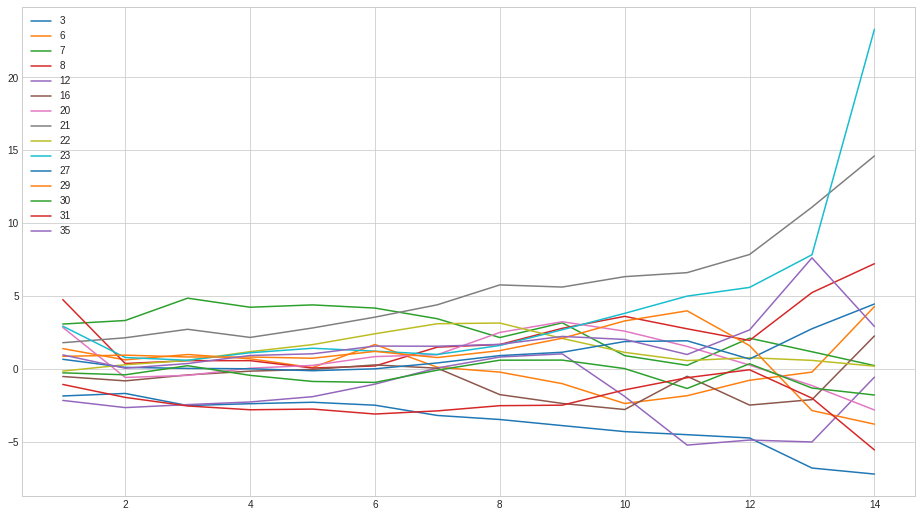

In [167]:
fig,ax = plt.subplots(figsize=(16,9))
for index in gt[gt['lo'] == 1].index:
    corr_list = []
    data = X[y.index(index)]
    # print(y[27])
    for t in times:
        corr_sum = 0
        for i,j in combinations(list(range(18)),2):
            # print(i,j)
            # print(data.shape)
            corr = np.corrcoef(data[i][250*t:],data[j][250*t:])
            # print(corr[0][1])
            corr_sum += corr[0][1]
        # print(t, corr_sum)
        corr_list.append(corr_sum)
    ax.plot(times,corr_list,label=index)
ax.legend()
plt.show()